### Lab 3: Expectation Maximization and Variational Autoencoder

### Machine Learning 2 (2020)

* Only a (random) selection of the problems will be graded (unknown to the students in advance). Those points will count as bonus. The average grade obtained will be added as a bonus (up to max 1pt) to the final grade (before rounding).
* The deadline is Friday, October 16th, 17:00.
* Assignment should be submitted through Canvas! Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file should be "studentid1\_lab#", for example, the attached file should be "12345\_lab1.ipynb". 

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask.
* Use __one cell__ for code and markdown answers only!
    * Put all code in the cell with the ```# YOUR CODE HERE``` comment and overwrite the ```raise NotImplementedError()``` line.
    * For theoretical questions, put your solution using LaTeX style formatting in the YOUR ANSWER HERE cell.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Large parts of you notebook will be graded automatically. Therefore it is important that your notebook can be run completely without errors and within a reasonable time limit. To test your notebook before submission, select Kernel -> Restart \& Run All.

### Installing PyTorch

In this lab we will use PyTorch. PyTorch is an open source deep learning framework primarily developed by Facebook's artificial-intelligence research group. In order to install PyTorch in your conda environment go to https://pytorch.org and select your operating system, conda, Python 3.6, no cuda. Copy the text from the "Run this command:" box. Now open a terminal and activate your 'ml2labs' conda environment. Paste the text and run. After the installation is done you should restart Jupyter.

### MNIST data

In this Lab we will use several methods for unsupervised learning on the MNIST dataset of written digits. The dataset contains digital images of handwritten numbers $0$ through $9$. Each image has 28x28 pixels that each take 256 values in a range from white ($= 0$) to  black ($=1$). The labels belonging to the images are also included. 
Fortunately, PyTorch comes with a MNIST data loader. The first time you run the box below it will download the MNIST data set. That can take a couple of minutes.
The main data types in PyTorch are tensors. For Part 1, we will convert those tensors to numpy arrays. In Part 2, we will use the torch module to directly work with PyTorch tensors.

In [1]:
%pylab inline
import torch
from torchvision import datasets, transforms

train_dataset = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

train_labels = train_dataset.train_labels.numpy()
train_data = train_dataset.train_data.numpy()
# For EM we will use flattened data
train_data = train_data.reshape(train_data.shape[0], -1)


Populating the interactive namespace from numpy and matplotlib


/Users/Yke/Desktop/AI/Year2/RL/venv/miniconda3/envs/ml2labs/lib/python3.6/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/Users/Yke/Desktop/AI/Year2/RL/venv/miniconda3/envs/ml2labs/lib/python3.6/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


## Part 1: Expectation Maximization
We will use the Expectation Maximization (EM) algorithm for the recognition of handwritten digits in the MNIST dataset. The images are modelled as a Bernoulli mixture model (see Bishop $\S9.3.3$):
$$
p(\bx|\bmu, \bpi) = \sum_{k=1}^K  \pi_k \prod_{i=1}^D \mu_{ki}^{x_i}(1-\mu_{ki})^{(1-x_i)}
$$
where $x_i$ is the value of pixel $i$ in an image, $\mu_{ki}$ represents the probability that pixel $i$ in class $k$ is black, and $\{\pi_1, \ldots, \pi_K\}$ are the mixing coefficients of classes in the data. We want to use this data set to classify new images of handwritten numbers.

### 1.1 Binary data (5 points)
As we like to apply our Bernoulli mixture model, write a function `binarize` to convert the (flattened) MNIST data to binary images, where each pixel $x_i \in \{0,1\}$, by thresholding at an appropriate level.

In [2]:
def binarize(X):
    # YOUR CODE HERE
    threshold = 255/2
    Xb = np.where(X <= threshold, 0., 1.)
    return Xb

In [3]:
# Test test test!
bin_train_data = binarize(train_data)
assert bin_train_data.dtype == np.float
assert bin_train_data.shape == train_data.shape


Sample a few images of digits $2$, $3$ and $4$; and show both the original and the binarized image together with their label.

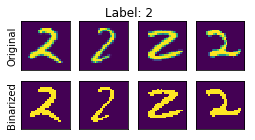

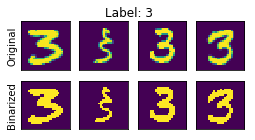

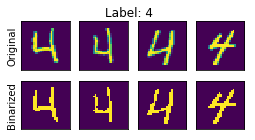

In [4]:
# YOUR CODE HERE
def sample_digit(digit, data, labels, N=1, replace=False):
    # this function is not used here, as it does not keep track of which datapoints were selected
    # but it might be useful later
    selection = data[labels == digit]
    return np.random.permutation(selection)[:N]

def show_digit(x, show=False, cmap_bin=False):
    if cmap_bin:
        plt.imshow(x.reshape(28,28), cmap="binary")
    else:
        plt.imshow(x.reshape(28,28))
    plt.xticks([]), plt.yticks([])
    if show:
        plt.show()
    
Nsamples = 4
digits = [2,3,4]
for digit in digits:
    digit_indc, = np.where(train_labels == digit)
    indc_choice = np.random.choice(digit_indc, Nsamples, replace=False)
    plt.figure(figsize=(Nsamples, 2))
    plt.suptitle(f"Label: {digit}")
    for n in range(Nsamples):
        plt.subplot(2,Nsamples,n+1)
        show_digit(train_data[indc_choice[n]])
        if n == 0:
            plt.ylabel("Original")
        plt.subplot(2,Nsamples,n+1+Nsamples)
        show_digit(bin_train_data[indc_choice[n]])
        if n == 0:
            plt.ylabel("Binarized")
    plt.show()

### 1.2 Implementation (40 points)
You are going to write a function ```EM(X, K, max_iter)``` that implements the EM algorithm on the Bernoulli mixture model. 

The only parameters the function has are:
* ```X``` :: (NxD) array of input training images
* ```K``` :: size of the latent space
* ```max_iter``` :: maximum number of iterations, i.e. one E-step and one M-step

You are free to specify your return statement.

Make sure you use a sensible way of terminating the iteration process early to prevent unnecessarily running through all epochs. Vectorize computations using ```numpy``` as  much as possible.

You should implement the `E_step(X, mu, pi)` and `M_step(X, gamma)` separately in the functions defined below. These you can then use in your function `EM(X, K, max_iter)`.

In [5]:
def bernoulli(x, mu):
    #input: x [1xD], mu [KxD]
    return np.prod(mu**x * (1-mu)**(1-x), axis=1)


def E_step(X, mu, pi):
    # YOUR CODE HERE
    N, _ = X.shape  # (NxD)
    K, = pi.shape  # (K,)
    
    gamma = np.zeros((N,K))
    
    for n in range(N):
        numerators = pi * bernoulli(X[n], mu)
        gamma[n,:] = numerators / np.sum(numerators)
        
    return gamma

In [6]:
# Let's test on 5 datapoints
n_test = 5
X_test = bin_train_data[:n_test]
D_test, K_test = X_test.shape[1], 10

np.random.seed(2018)
mu_test = np.random.uniform(low=.25, high=.75, size=(K_test,D_test))
pi_test = np.ones(K_test) / K_test

gamma_test = E_step(X_test, mu_test, pi_test)
assert gamma_test.shape == (n_test, K_test)


In [7]:
def M_step(X, gamma):
    # YOUR CODE HERE
    N, D = X.shape 
    _, K = gamma.shape
    
    Nk = np.sum(gamma, axis=0)
    pi = Nk / N
    
    mu = np.zeros((K,D))
    for k in range(K):
        mu[k,:] = 1/Nk[k] * gamma[:,k].T @ X
        
    return mu, pi

In [8]:
# Oh, let's test again
mu_test, pi_test = M_step(X_test, gamma_test)

assert mu_test.shape == (K_test,D_test)
assert pi_test.shape == (K_test, )


In [9]:
def EM(X, K, max_iter, mu=None, pi=None):
    # YOUR CODE HERE
    threshold = 0.01  # for early termination (low enough for purpose of exercise)
    N, D = X.shape
    
    if pi is None: # from Bishop
        pi = np.ones((K,)) / K
    if mu is None: # from Bishop
        mu = np.random.uniform(0.25, 0.75, (K,D))
        
    for step in range(max_iter):
        
        mu_prev, pi_prev = np.copy(mu), np.copy(pi)
        gamma = E_step(X, mu, pi)
        mu, pi = M_step(X, gamma)
        
        if max(np.linalg.norm(mu-mu_prev), np.linalg.norm(pi-pi_prev)) < threshold:
            print(f"Terminating early after {step} steps")
            break
        
    return mu, pi, gamma

### 1.3 Three digits experiment (10 points)
In analogue with Bishop $\S9.3.3$, sample a training set consisting of only __binary__ images of written digits $2$, $3$, and $4$. Run your EM algorithm and show the reconstructed digits.

Terminating early after 17 steps
Identified mixing coefficients: [0.32811347 0.35841244 0.31347409]
True mixing coefficients: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


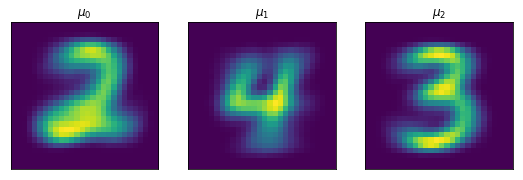

In [10]:
# YOUR CODE HERE

Nsamples = 2000  # samples per digit
digits = [2,3,4]
K = len(digits) # true number of classes
X = np.zeros((Nsamples*K, 28*28))  # data
T = np.zeros(Nsamples*K, dtype=int)  # targets
for i, digit in enumerate(digits):
    X[i*Nsamples:(i+1)*Nsamples,:] = sample_digit(digit, bin_train_data , train_labels, N=Nsamples)
    T[i*Nsamples:(i+1)*Nsamples] = np.array([digit]*Nsamples)
# X = np.random.permutation(X)  # doesnt matter
mu, pi, gamma = EM(X, K, 100)

print(f"Identified mixing coefficients:", pi)
print(f"True mixing coefficients:", [1./K]*K)
plt.figure(figsize=(3*K,3))
for k in range(K):
    plt.subplot(1,K,k+1)
    plt.title(f"$\mu_{k}$")
    show_digit(mu[k])  
plt.show()

Can you identify which element in the latent space corresponds to which digit? What are the identified mixing coefficients for digits $2$, $3$ and $4$, and how do these compare to the true ones?

YOUR ANSWER HERE

There is a clear distinction visible between the digits corresponding to the latent spaces. I can recognize the 2, 3 and 4 from the result of applying the EM-algorithm. The identified and true mixing coefficients are given. Although not perfect, the identified coefficient are close to the true ones, also considering our small number of update steps. However, it must be noted that the initialized pi already started with the correct coefficients, because I took an equal number of samples per digit.

### 1.4 Experiments (20 points)
Perform the follow-up experiments listed below using your implementation of the EM algorithm. For each of these, describe/comment on the obtained results and give an explanation. You may still use your dataset with only digits 2, 3 and 4 as otherwise computations can take very long.

#### 1.4.1 Size of the latent space (5 points)
Run EM with $K$ larger or smaller than the true number of classes. Describe your results.

K smaller (-1) than true number of classes
Terminating early after 7 steps
Identified mixing coefficients: [0.37647271 0.62352729]
True mixing coefficients: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


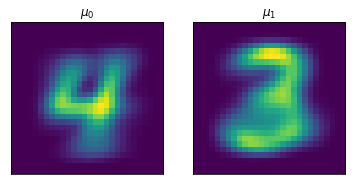

K larger (+1) than true number of classes
Terminating early after 20 steps
Identified mixing coefficients: [0.28964359 0.1696829  0.18329579 0.35737773]
True mixing coefficients: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


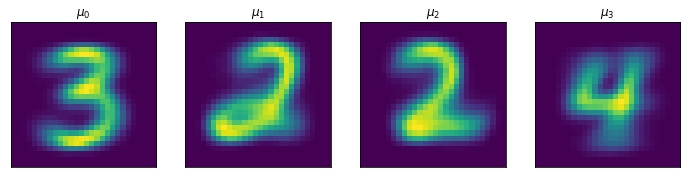

In [11]:
# YOUR CODE HERE

print("K smaller (-1) than true number of classes")
mu_Kmin, pi_Kmin, _ = EM(X, K-1, 100)

print(f"Identified mixing coefficients:", pi_Kmin)
print(f"True mixing coefficients:", [1./K]*K)
plt.figure(figsize=(3*(K-1),3))
for k in range(K-1):
    plt.subplot(1,K-1,k+1)
    plt.title(f"$\mu_{k}$")
    show_digit(mu_Kmin[k])  
plt.show()

print("K larger (+1) than true number of classes")
mu_Kplus, pi_Kplus, _ = EM(X, K+1, 100)

print(f"Identified mixing coefficients:", pi_Kplus)
print(f"True mixing coefficients:", [1./K]*K)
plt.figure(figsize=(3*(K+1),5))
for k in range(K+1):
    plt.subplot(1,K+1,k+1)
    plt.title(f"$\mu_{k}$")
    show_digit(mu_Kplus[k])  
plt.show()

YOUR ANSWER HERE

In the first case, where K is chosen smaller than the real number of classes, we can see that samples of different classes are taken together. In some cases, we can clearly see a 4 and a 3, but the 2 is "missing". In that case the 2 is somewhat present in both the representations of 3 and 4, or mixed up with one of them. If one of the classes has a mixing coefficient of about the true mixing coefficient and it clearly represents a class/digit, then then other representations are likely a mix of the remaining classes.

In the second case, with K smaller than the real number of classes, we see that the model has the freedom to design an extra class. This could be by deviding the most common appearances of a digit in two separate classes. For example, a 3 could be leaning to the left or to the right. The corresponding classes could then become 2, 4, 3(left), 3(right). We can see that back in the mixing coefficient, where 2 and 4 have nearly correct coeffients, and the other two are then half of that coefficient. This same phenomenon could occur for any permutation of 2, 3 and 4 in this explanation.

#### 1.4.2 Identify misclassifications (10 points)
How can you use the data labels to assign a label to each of the clusters/latent variables? Use this to identify images that are 'misclassified' and try to understand why they are. Report your findings.

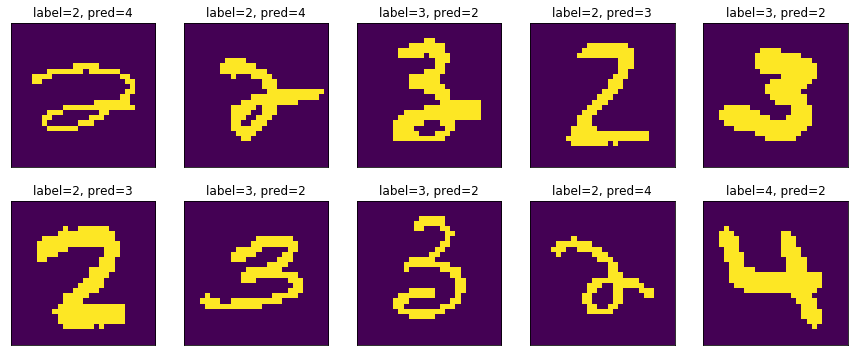

In [12]:
# YOUR CODE HERE
# first determine which latent spaces correspond to which digit
latent_classes = []
mu_init = np.zeros((K,28*28)) # for next question
for i, digit in enumerate(digits):
    digit_avg = np.mean(X[i*Nsamples:(i+1)*Nsamples,:], axis=0)
    mu_init[i,:] = np.copy(digit_avg)
    # identify classes based on L2 norm of the difference of means (predicted - true)
    latent_classes.append(digits[np.argmin([np.linalg.norm(mu_k - digit_avg) for mu_k in mu])])
assert len(np.unique(latent_classes)) == len(latent_classes), "Cannot distinguish classes with current method"

Y = np.array([latent_classes[i] for i in np.argmax(gamma, axis=1)])  # predictions

# filter misclassified samples
T_incorrect = T[Y != T]
Y_incorrect = Y[Y != T]
X_incorrect = X[Y != T]
indc = np.random.choice(range(len(Y_incorrect)), 10, replace=False) # samples to show
plt.figure(figsize=(3*5,3*2))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(f"label={T_incorrect[indc[i]]}, pred={Y_incorrect[indc[i]]}")
    show_digit(X_incorrect[indc[i]])
    


YOUR ANSWER HERE

We can take the (true) mean of each digit in our data selection individually and compare it with the predicted means of the latent classes using their squared distance. Once we figured which class belongs to which digit we can filter out the misclassified ones. A sample of those is shown above. We can quickly see that some of these do not represent the "average" digit of the corresponding kind. E.g. we can see some highly slanted ones (do not read literally "1's"), or ones with some extra loop, making them more unique so to say from the average digits. This could have resulted that the EM-algorithm had them fit better in one of the other classes, and therefore "misclassified" them.

#### 1.4.3 Initialize with true values (5 points)
Initialize the three classes with the true values of the parameters and see what happens. Report your results.

Initial mu is the concatenation of the means of all digits


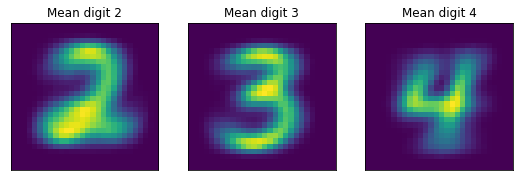

Terminating early after 6 steps
Identified mixing coefficients: [0.32665552 0.31863555 0.35470893]
True mixing coefficients: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


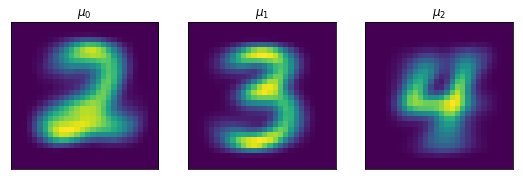

L2 norms of (mu_pred - mu_real): [0.523345217314653, 0.4862836020568332, 0.19506690841643043]


In [13]:
# YOUR CODE HERE

# pi is actually already initialized to the correct value
# data X has equal amount of samples for each digit
# mu_init is defined in the previous code cell when calculating the avg of each digit

print("Initial mu is the concatenation of the means of all digits")
plt.figure(figsize=(3*len(digits),3))
for i, digit_avg in enumerate(mu_init):
    plt.subplot(1,3,i+1)
    plt.title(f"Mean digit {digits[i]}")
    show_digit(digit_avg)
plt.show()
    
mu_, pi_, gamma_ = EM(X, K, 100, mu=mu_init, pi=np.ones((K,))/K)

print(f"Identified mixing coefficients:", pi_)
print(f"True mixing coefficients:", [1./K]*K)
plt.figure(figsize=(3*K,3))
for k in range(K):
    plt.subplot(1,K,k+1)
    plt.title(f"$\mu_{k}$")
    show_digit(mu_[k])  
plt.show()

print(f"L2 norms of (mu_pred - mu_real): {[np.linalg.norm(mu_[i]-mu_init[i]) for i in range(K)]}")

YOUR ANSWER HERE

The most apparent difference between using randomly initialized parameters and the true parameters as initialization, is that using the true parameters results in much faster termination of the algorithm (~6 steps instead of ~17). As can be seen, the predicted means are visually highly similar to the true means. However, the class distribution has deviated a bit from the actual distribution, and therefore also the predicted means. This could again be because some digits in the dataset just really resemble digits from the other class more then from their own class.

## Part 2: Variational Auto-Encoder

A Variational Auto-Encoder (VAE) is a probabilistic model $p(\bx, \bz)$ over observed variables $\bx$ and latent variables and/or parameters $\bz$. Here we distinguish the decoder part, $p(\bx | \bz) p(\bz)$ and an encoder part $p(\bz | \bx)$ that are both specified with a neural network. A lower bound on the log marginal likelihood $\log p(\bx)$ can be obtained by approximately inferring the latent variables z from the observed data x using an encoder distribution $q(\bz| \bx)$ that is also specified as a neural network. This lower bound is then optimized to fit the model to the data. 

The model was introduced by Diederik Kingma (during his PhD at the UVA) and Max Welling in 2013, https://arxiv.org/abs/1312.6114. 

Since it is such an important model there are plenty of well written tutorials that should help you with the assignment. E.g: https://jaan.io/what-is-variational-autoencoder-vae-tutorial/.

In the following, we will make heavily use of the torch module, https://pytorch.org/docs/stable/index.html. Most of the time replacing `np.` with `torch.` will do the trick, e.g. `np.sum` becomes `torch.sum` and `np.log` becomes `torch.log`. In addition, we will use `torch.FloatTensor()` as an equivalent to `np.array()`. In order to train our VAE efficiently we will make use of batching. The number of data points in a batch will become the first dimension of our data tensor, e.g. A batch of 128 MNIST images has the dimensions [128, 1, 28, 28]. To check check the dimensions of a tensor you can call `.size()`.

### 2.1 Loss function
The objective function (variational lower bound), that we will use to train the VAE, consists of two terms: a log Bernoulli loss (reconstruction loss) and a Kullback–Leibler divergence. We implement the two terms separately and combine them in the end.
As seen in Part 1: Expectation Maximization, we can use a multivariate Bernoulli distribution to model the likelihood $p(\bx | \bz)$ of black and white images. Formally, the variational lower bound is maximized but in PyTorch we are always minimizing therefore we need to calculate the negative log Bernoulli loss and Kullback–Leibler divergence.

### 2.1.1 Negative Log Bernoulli loss (5 points)
The negative log Bernoulli loss is defined as,

\begin{align}
loss = - (\sum_i^D \bx_i \log \hat{\bx_i} + (1 − \bx_i) \log(1 − \hat{\bx_i})).
\end{align}

Write a function `log_bernoulli_loss` that takes a D dimensional vector `x`, its reconstruction `x_hat` and returns the negative log Bernoulli loss. Make sure that your function works for batches of arbitrary size.

In [14]:
def log_bernoulli_loss(x_hat, x):
    
    # YOUR CODE HERE
    loss = - torch.sum(x * torch.log(x_hat) + (1 - x) * torch.log(1 - x_hat), axis=1)
    loss = torch.mean(loss) # avg over batches
    return loss


In [15]:
### Test test test
x_test = torch.FloatTensor([[0.1, 0.2, 0.3, 0.4], [0.5, 0.6, 0.7, 0.8], [0.9, 0.9, 0.9, 0.9]])
x_hat_test = torch.FloatTensor([[0.11, 0.22, 0.33, 0.44], [0.55, 0.66, 0.77, 0.88], [0.99, 0.99, 0.99, 0.99]])

assert log_bernoulli_loss(x_hat_test, x_test) > 0.0
assert log_bernoulli_loss(x_hat_test, x_test) < 10.0


### 2.1.2 Negative Kullback–Leibler divergence (10 Points)
The variational lower bound (the objective to be maximized) contains a KL term $D_{KL}(q(\bz)||p(\bz))$ that can often be calculated analytically. In the VAE we assume $q = N(\bz, \mu, \sigma^2I)$ and $p = N(\bz, 0, I)$. Solve analytically!

YOUR ANSWER HERE

(inspiration from http://stanford.edu/~jduchi/projects/general_notes.pdf)

$
\begin{align}
D_{KL}(q(z)\|p(z)) &= \int q(z) \log \frac{q(z)}{p(z)} dz \\
&= \int q(z) (\log q(z) - \log p(z)) dz \\
&= \frac{1}{2} \int q(z) (-\log(|\sigma^2I|)-(z- \mu)^\top (\sigma^2 I)^{-1}(z-\mu) + z^\top z)dz \;\;\; \text{(after working out logs and cancelling out terms)} \\
&= -\frac{1}{2}\log|\sigma^2I| + \frac{1}{2} \int q(z) (tr(zz^\top) - tr((\sigma^2I)^{-1}(z-\mu)(z-\mu)^\top)dz \\
&= -\frac{1}{2}\log|\sigma^2I| - \frac{D}{2}  + \frac{1}{2}tr(\sigma^2I + \mu\mu^\top) \\
&= \frac{1}{2}(-\log|\sigma^2I| - D + tr(\sigma^2I) + \mu^\top\mu) \\
&= \frac{1}{2}(-D\log\sigma^2 - D + D\sigma^2 + \mu^\top\mu) 
\end{align} 
$
In the paper (https://arxiv.org/pdf/1312.6114.pdf), they derive $D_{KL}(q(z)\|p(z))$ to be:

$
\begin{align}
D_{KL}(q(z)\|p(z)) = -\frac{1}{2} \sum_{i=1}^D (1+ \log \sigma_i^2 - \mu_i^2 - \sigma_i^2),
\end{align}
$

which looks like the same thing.

Write a function `KL_loss` that takes two J dimensional vectors `mu` and `logvar` and returns the negative Kullback–Leibler divergence. Where `logvar` is $\log(\sigma^2)$. Make sure that your function works for batches of arbitrary size.

In [16]:
def KL_loss(mu, logvar):
    
    # YOUR CODE HERE

    loss = -1/2. * torch.sum(1 + logvar - mu**2 - torch.exp(logvar), axis=1)
    loss = torch.mean(loss) # avg over batches

    return loss


In [17]:
### Test test test
mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

assert KL_loss(mu_test, logvar_test) > 0.0
assert KL_loss(mu_test, logvar_test) < 10.0


### 2.1.3 Putting the losses together (5 points)
Write a function `loss_function` that takes a D dimensional vector `x`, its reconstruction `x_hat`, two J dimensional vectors `mu` and `logvar` and returns the final loss. Make sure that your function works for batches of arbitrary size.

In [18]:
def loss_function(x_hat, x, mu, logvar):
    
    # YOUR CODE HERE
    loss = log_bernoulli_loss(x_hat, x) + KL_loss(mu, logvar)
    return loss


In [19]:
x_test = torch.FloatTensor([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9]])
x_hat_test = torch.FloatTensor([[0.11, 0.22, 0.33], [0.44, 0.55, 0.66], [0.77, 0.88, 0.99]])
mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

assert loss_function(x_hat_test, x_test, mu_test, logvar_test) > 0.0
assert loss_function(x_hat_test, x_test, mu_test, logvar_test) < 10.0


### 2.2 The model
Below you see a data structure for the VAE. The modell itself consists of two main parts the encoder (images $\bx$ to latent variables $\bz$) and the decoder (latent variables $\bz$ to images $\bx$). The encoder is using 3 fully-connected layers, whereas the decoder is using fully-connected layers. Right now the data structure is quite empty, step by step will update its functionality. For test purposes we will initialize a VAE for you. After the data structure is completed you will do the hyperparameter search.


In [20]:
from torch import nn
from torch.nn import functional as F 

class VAE(nn.Module):
    def __init__(self, fc1_dims, fc21_dims, fc22_dims, fc3_dims, fc4_dims):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(*fc1_dims)
        self.fc21 = nn.Linear(*fc21_dims)
        self.fc22 = nn.Linear(*fc22_dims)
        self.fc3 = nn.Linear(*fc3_dims)
        self.fc4 = nn.Linear(*fc4_dims)

    def encode(self, x):
        # To be implemented
        raise Exception('Method not implemented')

    def reparameterize(self, mu, logvar):
        # To be implemented
        raise Exception('Method not implemented')

    def decode(self, z):
        # To be implemented
        raise Exception('Method not implemented')

    def forward(self, x):
        # To be implemented
        raise Exception('Method not implemented')

VAE_test = VAE(fc1_dims=(784, 4), fc21_dims=(4, 2), fc22_dims=(4, 2), fc3_dims=(2, 4), fc4_dims=(4, 784))


### 2.3 Encoding (10 points)
Write a function `encode` that gets a vector `x` with 784 elements (flattened MNIST image) and returns `mu` and `logvar`. Your function should use three fully-connected layers (`self.fc1()`, `self.fc21()`, `self.fc22()`). First, you should use `self.fc1()` to embed `x`. Second, you should use `self.fc21()` and `self.fc22()` on the embedding of `x` to compute `mu` and `logvar` respectively. PyTorch comes with a variety of activation functions, the most common calls are `F.relu()`, `F.sigmoid()`, `F.tanh()`. Make sure that your function works for batches of arbitrary size.  

In [21]:
def encode(self, x):
    
    # YOUR CODE HERE
    x = torch.relu(self.fc1(x))
    mu = self.fc21(x)
    logvar = self.fc22(x)
    return mu, logvar


In [22]:
### Test, test, test
VAE.encode = encode

x_test = torch.ones((5,784))
mu_test, logvar_test = VAE_test.encode(x_test)

assert np.allclose(mu_test.size(), [5, 2])
assert np.allclose(logvar_test.size(), [5, 2])


### 2.4 Reparameterization (10 points)
One of the major question that the VAE is answering, is 'how to take derivatives with respect to the parameters of a stochastic variable?', i.e. if we are given $\bz$ that is drawn from a distribution $q(\bz|\bx)$, and we want to take derivatives. This step is necessary to be able to use gradient-based optimization algorithms like SGD.
For some distributions, it is possible to reparameterize samples in a clever way, such that the stochasticity is independent of the parameters. We want our samples to deterministically depend on the parameters of the distribution. For example, in a normally-distributed variable with mean $\mu$ and standard deviation $\sigma$, we can sample from it like this:

\begin{align}
\bz = \mu + \sigma \odot \epsilon,
\end{align}

where $\odot$ is the element-wise multiplication and $\epsilon$ is sampled from $N(0, I)$.


Write a function `reparameterize` that takes two J dimensional vectors `mu` and `logvar`. It should return $\bz = \mu + \sigma \odot \epsilon$.


In [23]:
def reparameterize(self, mu, logvar):
            
    # YOUR CODE HERE
    e = torch.normal(0,1,logvar.shape)
    z = mu + torch.sqrt(torch.exp(logvar)) * e
    return z


In [24]:
### Test, test, test
VAE.reparameterize = reparameterize
VAE_test.train()

mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

z_test = VAE_test.reparameterize(mu_test, logvar_test)

assert np.allclose(z_test.size(), [3, 2])
assert z_test[0][0] < 5.0
assert z_test[0][0] > -5.0


### 2.5 Decoding (10 points)
Write a function `decode` that gets a vector `z` with J elements and returns a vector `x_hat` with 784 elements (flattened MNIST image). Your function should use two fully-connected layers (`self.fc3()`, `self.fc4()`). PyTorch comes with a variety of activation functions, the most common calls are `F.relu()`, `F.sigmoid()`, `F.tanh()`. Make sure that your function works for batches of arbitrary size.

In [25]:
def decode(self, z):
    
    # YOUR CODE HERE
    z = torch.relu(self.fc3(z))
    x_hat = torch.sigmoid(self.fc4(z)) # 'probabilities' of pixels being 1
    return x_hat


In [26]:
# test test test
VAE.decode = decode

z_test = torch.ones((5,2))
x_hat_test = VAE_test.decode(z_test)

assert np.allclose(x_hat_test.size(), [5, 784])
assert (x_hat_test <= 1).all()
assert (x_hat_test >= 0).all()


### 2.6 Forward pass (10)
To complete the data structure you have to define a forward pass through the VAE. A single forward pass consists of the encoding of an MNIST image $\bx$ into latent space $\bz$, the reparameterization of $\bz$ and the decoding of $\bz$ into an image $\bx$.

Write a function `forward` that gets a a vector `x` with 784 elements (flattened MNIST image) and returns a vector `x_hat` with 784 elements (flattened MNIST image), `mu` and `logvar`.

In [27]:
def forward(self, x):
    x = x.view(-1, 784)
    
    # YOUR CODE HERE
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    x_hat = self.decode(z)
    
    return x_hat, mu, logvar


In [28]:
# test test test 
VAE.forward = forward

x_test = torch.ones((5,784))
x_hat_test, mu_test, logvar_test = VAE_test.forward(x_test)

assert np.allclose(x_hat_test.size(), [5, 784])
assert np.allclose(mu_test.size(), [5, 2])
assert np.allclose(logvar_test.size(), [5, 2])


### 2.7 Training (15)
We will now train the VAE using an optimizer called Adam, https://arxiv.org/abs/1412.6980. The code to train a model in PyTorch is given below.

In [29]:
from torch.autograd import Variable

def train(epoch, train_loader, model, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data.view(-1, 784), mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


Let's train. You have to choose the hyperparameters. Make sure your loss is going down in a reasonable amount of epochs (around 10).

In [30]:
# Hyperparameters
x_dim = 28*28
n_hidden = 256
n_latent = 32

fc1_dims = (x_dim, n_hidden)
fc21_dims = (n_hidden, n_latent)
fc22_dims = fc21_dims
fc3_dims = (n_latent, n_hidden)
fc4_dims = (n_hidden, x_dim)
lr = 1e-3
batch_size = 64
epochs = 10

# YOUR CODE HERE

In [31]:
# This cell contains a hidden test, please don't delete it, thx

Run the box below to train the model using the hyperparameters you entered above.

In [32]:
from torchvision import datasets, transforms
from torch import nn, optim

# Load data
train_data = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, shuffle=True, **{})

# Init model
VAE_MNIST = VAE(fc1_dims=fc1_dims, fc21_dims=fc21_dims, fc22_dims=fc22_dims, fc3_dims=fc3_dims, fc4_dims=fc4_dims)

# Init optimizer
optimizer = optim.Adam(VAE_MNIST.parameters(), lr=lr)

# Train
for epoch in range(1, epochs + 1):
    train(epoch, train_loader, VAE_MNIST, optimizer)


Train Epoch: 1 [0/60000 (0%)]	Loss: 8.533616
Train Epoch: 1 [6400/60000 (11%)]	Loss: 3.123406
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.727120
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.467804
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.362454
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.266378
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.117543
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.073317
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.006711
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.015165
====> Epoch: 1 Average loss: 2.4734
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.070115
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.961610
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.788499
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.870733
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.017878
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.908627
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.825974
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.867459
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.851660
Train Epoch: 2 [57600/6000

Run the box below to check if the model you trained above is able to correctly reconstruct images.

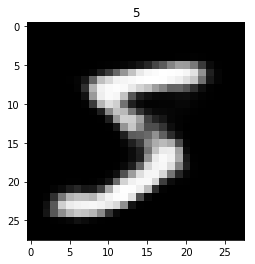

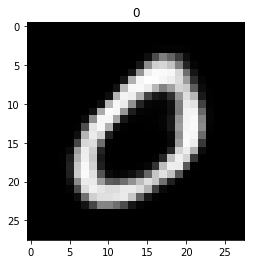

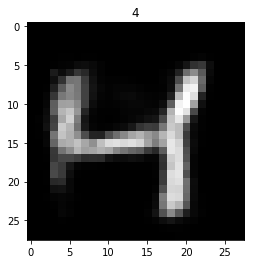

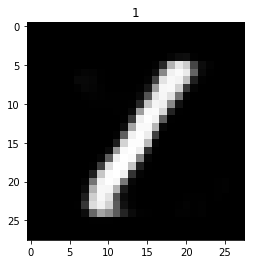

In [33]:
### Let's check if the reconstructions make sense
# Set model to test mode
VAE_MNIST.eval()
    
# Reconstructed
train_data_plot = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader_plot = torch.utils.data.DataLoader(train_data_plot,
                                           batch_size=1, shuffle=False, **{})

for batch_idx, (data, _) in enumerate(train_loader_plot):
    x_hat, mu, logvar = VAE_MNIST(data)
    plt.imshow(x_hat.view(1,28,28).squeeze().data.numpy(), cmap='gray')
    plt.title('%i' % train_data.train_labels[batch_idx])
    plt.show()
    if batch_idx == 3:
        break


### 2.8 Visualize latent space (20 points)
Now, implement the auto-encoder now with a 2-dimensional latent space, and train again over the MNIST data. Make a visualization of the learned manifold by using a linearly spaced coordinate grid as input for the latent space, as seen in  https://arxiv.org/abs/1312.6114 Figure 4.

Train Epoch: 1 [0/60000 (0%)]	Loss: 8.651705
Train Epoch: 1 [6400/60000 (11%)]	Loss: 3.183887
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.839237
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.738140
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.785741
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.943545
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.551213
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.646703
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.605179
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.684883
====> Epoch: 1 Average loss: 2.9068
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.558051
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.594514
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.492254
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.590971
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.584270
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.526478
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.541493
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.483778
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.645841
Train Epoch: 2 [57600/6000

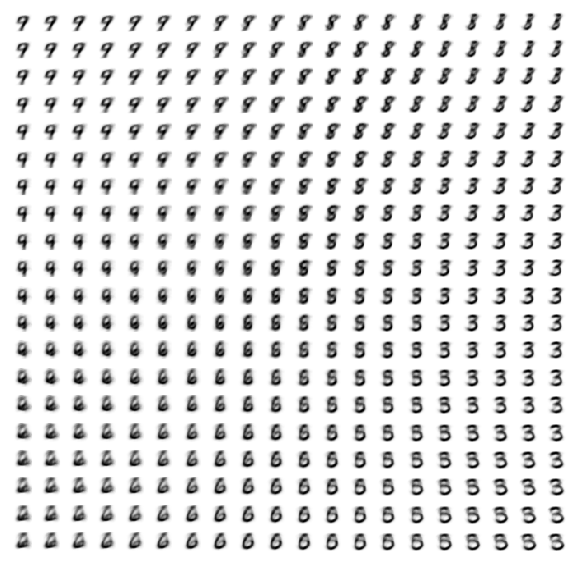

In [34]:
# YOUR CODE HERE

# change latent dimension to 2
n_latent = 2
fc1_dims = (x_dim, n_hidden)
fc21_dims = (n_hidden, n_latent)
fc22_dims = fc21_dims
fc3_dims = (n_latent, n_hidden)
fc4_dims = (n_hidden, x_dim)
lr = 1e-3
batch_size = 64
epochs = 5

# Init model
VAE_MNIST = VAE(fc1_dims=fc1_dims, fc21_dims=fc21_dims, fc22_dims=fc22_dims, fc3_dims=fc3_dims, fc4_dims=fc4_dims)

# Init optimizer
optimizer = optim.Adam(VAE_MNIST.parameters(), lr=lr)

# Train
for epoch in range(1, epochs + 1):
    train(epoch, train_loader, VAE_MNIST, optimizer)

VAE_MNIST.eval()

Nsamples = 20  # per dimension, so squared in total
show_binary = False

# sample from unit square
x_sq = np.linspace(-1,1,Nsamples)
y_sq = x_sq

plt.figure(figsize=(10,10))
for i in range(Nsamples):
    for j in range(Nsamples):
        z = torch.FloatTensor([x_sq[i],y_sq[j]]).view(1,2)
        with torch.no_grad():
            x_hat = VAE_MNIST.decode(z).view(28*28)
        if show_binary:
            x_hat = x_hat > 0.5
        plt.subplot(Nsamples,Nsamples,i*Nsamples+j+1)
        show_digit(x_hat, cmap_bin=True)
        plt.axis("off")
plt.show()

### 2.8 Amortized inference (10 points)
What is amortized inference? Where in the code of Part 2 is it used? What is the benefit of using it?


YOUR ANSWER HERE

(information from https://jaan.io/what-is-variational-autoencoder-vae-tutorial/)
When doing approximate inference to estimate a posterior distribution of latent variables, we can for example choose mean-field inference or amortized inference. In mean-field VI, the datapoints share no parameters in contrast to amortized VI, where parameters are shared between datapoints. Sharing of parameters can be useful because if we have less parameters to optimize for, our optimization can generally be done faster / more efficient. In part 2, all parameters in the encoder and decoder are shared between datapoints. In the encoder network we use amortized inference, using shared parameters, to map each datapoint to a mean and a variance (those may differ for each datapoint).